<a href="https://colab.research.google.com/github/zeemarquez/Rankine/blob/main/RankineCycle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Libraries

In [ ]:
!pip install coolprop

In [ ]:
import CoolProp.CoolProp as cp
from CoolProp.Plots import PropertyPlot 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from matplotlib.transforms import Bbox
import itertools as it
import warnings
import pylab
from scipy.optimize import minimize
from google.colab import files

warnings.filterwarnings('ignore')

In [ ]:
class State:

  kwargs_dict = {
        '_T' : 'T',
        '_P' : 'P',
        '_x' : 'Q',
        '_h' : 'H',
        '_s' : 'S',
        '_d' : 'D',
        '_c' : 'CPMASS'}
  
  def __init__(self, fluid, **kwargs):
    self.Fluid = fluid

    input_kwargs = {}
    for k in kwargs:
      input_kwargs['_'+k]= kwargs.get(k) 
    self.__dict__.update(input_kwargs)

  def __getProperty(self, key):

    if ('_' + key) in self.__dict__.keys():
      return self.__dict__.get('_' + key)
    else:
      output = State.kwargs_dict.get('_' + key)
      inputs = State.kwargs_dict.copy()
      inputs.pop('_' + key)
      combinations = list(it.combinations(inputs.keys(),2))
      result = None
      for x,y in combinations:
        try:
          result = cp.PropsSI(output , inputs.get(x) , self.__dict__.get(x), inputs.get(y), self.__dict__.get(y), self.Fluid )
        except:
          pass
        if result != None:
          break
          
      return result    
    
  def __eq__(self, obj):
    if self.Fluid == obj.Fluid:
      if (self.T == obj.T) and (self.s == obj.s):
        return True
      else:
        return False
    else:
      return False

  def getTable(self, label=0):
    df = pd.DataFrame(data={'T(ºC)':[self.T-273],'P(MPa)':[self.P/(1e6)],'h(kJ/kg)':[self.h/1000],'s(kJ/kgK)':[self.s/1000],'x(-)':[self.x]}, index=[label])
    return df

  @property
  def T(self):
    key = 'T'

    if '_' + key in self.__dict__.keys():
      return self.__dict__.get('_' + key)
    else:
      val = self.__getProperty(key)
      if val == None:
        raise Exception('Could not calculate ' + key)
      else:
        self.__dict__['_' + key] = val
        return val
  
  @property
  def P(self):
    key = 'P'
    
    if '_' + key in self.__dict__.keys():
      return self.__dict__.get('_' + key)
    else:
      val = self.__getProperty(key)
      if val == None:
        raise Exception('Could not calculate ' + key)
      else:
        self.__dict__['_' + key] = val
        return val
  @property
  def h(self):
    key = 'h'
    
    if '_' + key in self.__dict__.keys():
      return self.__dict__.get('_' + key)
    else:
      val = self.__getProperty(key)
      if val == None:
        raise Exception('Could not calculate ' + key)
      else:
        self.__dict__['_' + key] = val
        return val

  @property
  def s(self):
    key = 's'
    
    if '_' + key in self.__dict__.keys():
      return self.__dict__.get('_' + key)
    else:
      val = self.__getProperty(key)
      if val == None:
        raise Exception('Could not calculate ' + key)
      else:
        self.__dict__['_' + key] = val
        return val

  @property
  def x(self):
    key = 'x'
    
    if '_' + key in self.__dict__.keys():
      return self.__dict__.get('_' + key)
    else:
      val = self.__getProperty(key)
      if val == None:
        raise Exception('Could not calculate ' + key)
      else:
        self.__dict__['_' + key] = val
        return val

  @property
  def c(self):
    key = 'c'
    
    if '_' + key in self.__dict__.keys():
      return self.__dict__.get('_' + key)
    else:
      val = self.__getProperty(key)
      if val == None:
        raise Exception('Could not calculate ' + key)
      else:
        self.__dict__['_' + key] = val
        return val

  @property
  def d(self):
    key = 'd'
    
    if '_' + key in self.__dict__.keys():
      return self.__dict__.get('_' + key)
    else:
      val = self.__getProperty(key)
      if val == None:
        raise Exception('Could not calculate ' + key)
      else:
        self.__dict__['_' + key] = val
        return val
    

class StepType:
  isobaric = 'isobaric'
  isentropic = 'isentropic'


class Cycle:

  cycleDefinition = 500

  def __init__(self, mass_flow, initial_state):
    self.fluid = initial_state.Fluid
    self.mass_flow = mass_flow
    self.states = [initial_state]
        
    self.T_array = []
    self.s_array = []
    self.P_array = []
    self.h_array = []

    self.points_T = []
    self.points_s = []
    self.points_P = []
    self.points_h = []

    self.heat_in = 0
    self.heat_out = 0
  
  @property
  def work_net(self):
    return (self.heat_in - self.heat_out)
  
  @property
  def efficiency(self):
    return (1- (self.heat_out/self.heat_in))

  def isCycleValid(self):
    if len(self.states) > 1:
      return self.states[0] == self.states[-1]
    else:
      return False

  def addStep(self, stepType, state):

    sta = self.states[-1]
    stb = state
    self.__addStepPoints(sta,stb,stepType)
    self.states.append(state)

  def plotTs(self):

    if self.isCycleValid():

      s_array_kj = [x/1000 for x in self.s_array]
      points_s_kj = [x/1000 for x in self.points_s]
      T_array_C = [x-273 for x in self.T_array]
      points_T_C = [x-273 for x in self.points_T]

      ts_plot = PropertyPlot(self.fluid, 'Ts', unit_system='EUR')
      ts_plot.calc_isolines(cp.iP, num=20)
      ts_plot.calc_isolines(cp.iQ, num=10)
      ts_plot.axis.plot(s_array_kj,T_array_C, color = 'red')
      ts_plot.axis.plot(points_s_kj,points_T_C, 'bo')
      ts_plot.title(r'$T,s$ graph for ' + self.fluid)
      ts_plot.xlabel(r'$s$ [kJ/kg K]')
      ts_plot.ylabel(r'$T$ [ºC]')

      min_s = min(points_s_kj)
      if min_s < 0:
        min_s = 1.1 * min_s
      else:
        min_s = 0.8 * min_s

      min_T = min(points_T_C)
      if min_T < 0:
        min_T = 1.1 * min_T
      else:
        min_T = 0.8 * min_T

      plt.axis([min_s, 1.1 * max(s_array_kj), min_T, 1.1 * max(T_array_C)])

      ts_plot.grid()
      ts_plot.show()

      self.Ts_plot = ts_plot

    else:
      raise Exception("Cycle is not valid. Check that the end step closes the cycle")
  
  def plotPh(self):
    if self.isCycleValid():

      s_array_kj = [x/1000 for x in self.h_array]
      points_s_kj = [x/1000 for x in self.points_h]
      P_array_kPa = [x/1000 for x in self.P_array]
      points_P_kPa = [x/1000 for x in self.points_P]

      ts_plot = PropertyPlot(self.fluid, 'ph')
      ts_plot.calc_isolines(cp.iQ, num=10)
      ts_plot.calc_isolines(cp.iT, num=10)


      ts_plot.axis.plot(s_array_kj,P_array_kPa, color = 'red')
      ts_plot.axis.plot(points_s_kj,points_P_kPa, 'bo')

      ts_plot.title(r'$P,h$ graph for ' + self.fluid)
      ts_plot.xlabel(r'$h$ [kJ/kg]')
      ts_plot.ylabel(r'$P$ [kPa]')

      P_crit = cp.PropsSI("Pcrit","",0,"",0,self.fluid)

      plt.axis([0, 1.1 * max(s_array_kj), 0, 1.5 * max(P_crit/1000,max(P_array_kPa))])

      ts_plot.grid()
      ts_plot.show()

      self.Ph_plot = ts_plot

    else:
      raise Exception("Cycle is not valid. Check that the end step closes the cycle")


  def printTable(self):
    print()
    print('----------------------------------------')
    print('Fluid:\t\t', self.fluid)
    print('----------------------------------------')
    print('Mass flow:\t', round(self.mass_flow,2), '\t\t (kg/s)')
    print('Heat in:\t', round(self.heat_in/1000,2), '\t (kW)')
    print('Heat out:\t', round(self.heat_out/1000,2), '\t (kW)')
    print('Work net:\t', round(self.work_net/1000,2), '\t (kW)')
    print('Efficiency:\t', round(self.efficiency*100,2), '\t\t (%)')
    print('----------------------------------------')
    print()


  def __addStepPoints(self, state_a, state_b, stepType):

    N = Cycle.cycleDefinition
    s = state_a.s
    Ta = state_a.T
    ds = (state_b.s - state_a.s)/N
    dT = (state_b.T - state_a.T)/N

    step_T_array = []
    step_s_array = []
    step_P_array = []
    setp_h_array = []

    self.points_T.append(state_a.T)
    self.points_T.append(state_b.T)
    self.points_s.append(state_a.s)
    self.points_s.append(state_b.s)
    
    self.points_P.append(state_a.P)
    self.points_P.append(state_b.P)
    self.points_h.append(state_a.h)
    self.points_h.append(state_b.h)

    for n in range(N):

      s += ds

      if stepType == StepType.isobaric:
        T = State(self.fluid, P = state_a.P, s = s).T
        P = state_a.P
      elif stepType == StepType.isentropic:
        T = Ta + n*dT
        P = State(self.fluid, T = T, s = s).P
      

      try:
        h = State(self.fluid, T = T, s = s).h
      except:
        h = State(self.fluid, T = T-1.0, s = s).h
      
      self.T_array.append(T)
      self.s_array.append(s)
      self.P_array.append(P)
      self.h_array.append(h)
      step_T_array.append(T)
      step_s_array.append(s)
      step_P_array.append(P)
      setp_h_array.append(h)

    integral = np.trapz(y=step_T_array,x=step_s_array)

    if integral > 0:
      self.heat_in += integral*self.mass_flow
    else:
      self.heat_out += abs(integral)*self.mass_flow


class SimpleRankine:

  def __init__(self,mass_flow,fluid, st_turb_in, st_cond_in, st_pump_in, st_boil_in):
    self.mass_flow = mass_flow
    self.fluid = fluid
    self.st_turb_in = st_turb_in
    self.st_cond_in = st_cond_in
    self.st_pump_in = st_pump_in
    self.st_boil_in = st_boil_in

  @property
  def work_turb(self):
    return self.mass_flow*(self.st_turb_in.h- self.st_cond_in.h)
  
  @property
  def work_pump(self):
    return self.mass_flow*(self.st_boil_in.h- self.st_pump_in.h)

  @property
  def work_net(self):
    return self.work_turb - self.work_pump

  @property
  def heat_in(self):
    return self.mass_flow*(self.st_turb_in.h- self.st_boil_in.h)

  @property
  def heat_out(self):
    return self.mass_flow*(self.st_cond_in.h- self.st_pump_in.h)

  @property
  def efficiency(self):
    return (self.work_net/self.heat_in)

  def plotGraphs(self):
    self.cycle = Cycle(self.mass_flow,self.st_pump_in)
    self.cycle.addStep(StepType.isentropic, self.st_boil_in)
    self.cycle.addStep(StepType.isobaric, self.st_turb_in)
    self.cycle.addStep(StepType.isentropic, self.st_cond_in)
    self.cycle.addStep(StepType.isobaric, self.st_pump_in)

    self.cycle.plotTs()
    self.cycle.plotPh()

    self.cycle.Ts_plot.savefig("Ts_plot.png")
    self.cycle.Ph_plot.savefig("Ph_plot.png")


  def printTable(self):
    print()
    print('----------------------------------------')
    print('Fluid:\t\t', self.fluid)
    print('----------------------------------------')
    print('Mass flow:\t', round(self.mass_flow,2), '\t\t (kg/s)')
    print('Heat in:\t', round(self.heat_in/1000,2), '\t (kW)')
    print('Heat out:\t', round(self.heat_out/1000,2), '\t (kW)')
    print('Work turbine:\t', round(self.work_turb/1000,2), '\t (kW)')
    print('Work pump:\t', round(self.work_pump/1000,2), '\t (kW)')
    print('Work net:\t', round(self.work_net/1000,2), '\t (kW)')
    print('Efficiency:\t', round(self.efficiency*100,2), '\t\t (%)')
    print('----------------------------------------')
    print()

  def getDf(self):

    P_high = self.st_boil_in.P/1.0e6
    P_low = self.st_cond_in.P/1.0e6

    df = pd.DataFrame()


    df = df.append(pd.DataFrame([['Fluid:', self.fluid, '-']]))
    df = df.append(pd.DataFrame([['Mass flow', round(self.mass_flow,2), '(kg/s)']]))
    df = df.append(pd.DataFrame([['Heat in', round(self.heat_in/1000,2), '(kW)']]))
    df = df.append(pd.DataFrame([['Heat out', round(self.heat_out/1000,2), '(kW)']]))
    df = df.append(pd.DataFrame([['Work turbine', round(self.work_turb/1000,2), '(kW)']]))
    df = df.append(pd.DataFrame([['Work pump', round(self.work_pump/1000,2), '(kW)']]))
    df = df.append(pd.DataFrame([['Work net', round(self.work_net/1000,2), '(kW)']]))
    df = df.append(pd.DataFrame([['Efficiency', round(self.efficiency*100,2), '(%)']]))
    df = df.append(pd.DataFrame([['P high', round(P_high, 3), 'MPa']]))
    df = df.append(pd.DataFrame([['P low', round(P_low, 3), 'MPa']]))
    return df


def plotTs(fluid):
  ts_plot = PropertyPlot(fluid, 'Ts', unit_system='EUR')
  ts_plot.calc_isolines(cp.iP, num=10)
  ts_plot.calc_isolines(cp.iQ, num=10)
  ts_plot.title(r'$T,s$ graph for ' + fluid)
  ts_plot.xlabel(r'$s$ [kJ/kg K]')
  ts_plot.ylabel(r'$T$ [ºC]')
  ts_plot.grid()

  ts_plot.show()

def plotPh(fluid):
  ts_plot = PropertyPlot(fluid, 'Ph')
  ts_plot.calc_isolines(cp.iQ, num=10)
  ts_plot.calc_isolines(cp.iT, num=10)
  ts_plot.title(r'$P,h$ graph for ' + fluid)
  ts_plot.xlabel(r'$h$ [kJ/kg]')
  ts_plot.ylabel(r'$P$ [kPa]')
  ts_plot.grid()

  ts_plot.show()


def eng(value, units, digits = 3):
  symbols = {-6:'micro', -3:'m', 0:'', 3:'k', 6:'M', 9:'G'}
  pow = 0

  if value > 1000.0:
    while value > 1000.0:
      pow += 3
      value = value/1000.0
      if pow >= 9:
        break

  elif value < 1:
    while value < 1:
      pow -= 3
      value = value * 1000.0
      if pow <= -6:
        break

  return str(round(value, digits)) + ' ' + symbols[pow] + units


# Main Program

In [ ]:
#@title $CO_2$ Well parameters
P_co2_injection_MPa =  45.0 #@param {type:"number"}
T_co2_injection_C =  15.0 #@param {type:"number"}
P_co2_inlet_MPa =  36.065991 #@param {type:"number"}
T_co2_inlet_C =  89.0 #@param {type:"number"}
m_co2_injection =   12.0#@param {type:"number"}

m_co2 = m_co2_injection - 3.24

df_inputs = pd.DataFrame([
                          ['P CO2 Injection',P_co2_injection_MPa,'MPa'],
                          ['P CO2 Inlet',P_co2_inlet_MPa,'MPa'],
                          ['T CO2 Injection',T_co2_injection_C,'ºC'],
                          ['T CO2 Inlet',T_co2_inlet_C,'ºC'],
                          ['m CO2 injection',m_co2_injection,'kg/s'],
                          ['m CO2 H.E',m_co2,'kg/s']
                          ])

df_inputs

,0,1,2
0,P CO2 Injection,45.000000,MPa
1,P CO2 Inlet,36.065991,MPa
2,T CO2 Injection,15.000000,ºC
3,T CO2 Inlet,89.000000,ºC
4,m CO2 injection,12.000000,kg/s
5,m CO2 H.E,8.760000,kg/s


## $CO_2$ Properties

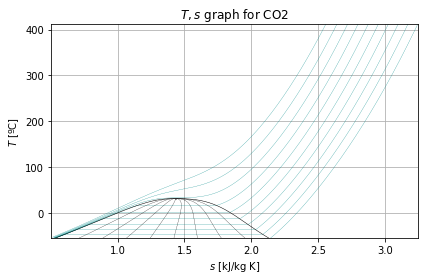

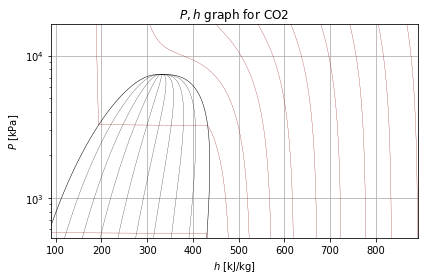

In [ ]:
#@title Plot Cycle Fluid Diagrams
fluid = "CO2" #@param ["water", "R134a", "CO2", "ammonia"]
plotTs(fluid)
plotPh(fluid)

## Optimize Simple Rankine

In [ ]:
#@title Optimization parameters
fluid = "R134a" #@param ["water", "R134a", "CO2", "ammonia"]
dP_min_kPa =  5#@param {type:"number"}
dP_max_MPa =  30#@param {type:"number"}
maximize = "work_net" #@param ["work_net", "efficiency", "heat_in"]

In [ ]:
inputs0 = [2e6,500e3,6.5] #[P_high, P_low, mass_flow]

dP_min = dP_min_kPa * 1e3
dP_max = dP_max_MPa * 1e6

def get_rankine(inputs):

  P_high  = inputs[0]
  P_low   = inputs[1]
  m_cycle = inputs[2]

  m_geo = m_co2  #kg/s
  #boiler_efficiency = 0.9
  P_co2 = P_co2_inlet_MPa * 1e6
  T_hot_geo = T_co2_inlet_C + 273

  st_cond = State(fluid, x=0, P=P_low)
  T_condenser = st_cond.T

  st_boil_in = State(fluid,s= st_cond.s,P=P_high)
  T_boil_in = st_boil_in.T


  C_co2, C_fluid = State('CO2', P = P_co2, T=T_hot_geo).c * m_geo , State(fluid, P = P_high, T=T_boil_in).c * m_cycle
  C_min = min(C_co2, C_fluid)

  Q_max = C_min*(T_hot_geo-T_boil_in)

  co2_in = State('CO2', P = P_co2, T=T_hot_geo)
  co2_out = State('CO2', P = P_co2, T=co2_in.T - (Q_max/C_co2))

  st1 = st_cond
  st2 = st_boil_in
  st3 = State(fluid, P=P_high, T = st2.T + (Q_max/C_fluid))
  #st3 = State(fluid, P=P_high, h = st2.h + (Q_max/m_cycle))
  st4 = State(fluid, P=P_low, s=st3.s)

  rankine = SimpleRankine(m_cycle,fluid,st3,st4,st1,st2)

  return rankine

rk0 = get_rankine(inputs0)

def objective(inputs):
  
  failed = True
  try:
    rk = get_rankine(inputs)
    failed = False
  except:
    pass

  if maximize == 'work_net':
    if failed:
      return 1e6/(rk0.work_net)
    else:
      return 1e6/(rk.work_net)
  elif maximize == 'efficiency':
    if failed:
      return 1/(rk0.efficiency)
    else:
      return 1/(rk.efficiency)


#[P_high, P_low, mass_flow]

def constraint1(inputs):
  return -inputs[0] + inputs[1] + dP_max

def constraint2(inputs):
  return -dP_min - inputs[1] + inputs[0]

bnds = [(100e3,20e6),(100e3,20e6),(0.5,30.0)]

con1 = {'type':'ineq', 'fun': constraint1}
con2 = {'type':'ineq', 'fun': constraint2}

cons = [con1,con2]

solution = minimize(objective, inputs0, method='SLSQP', bounds=bnds, constraints=cons)

print('Maximum net Work:',eng(get_rankine(solution.x).work_net,'W'))
print('Inputs:',solution.x)
print('\n------------------------')
print('P high:\t', eng(solution.x[0],'Pa'))
print('P low:\t', eng(solution.x[1],'Pa'))
print('m flow:\t', eng(solution.x[2],'kg/s'))
print('------------------------')

Maximum net Work: 448.713 kW
Inputs: [2.00000000e+06 5.00000000e+05 1.72664382e+01]

------------------------
P high:	 2.0 MPa
P low:	 500.0 kPa
m flow:	 17.266 kg/s
------------------------


### Results


----------------------------------------
Fluid:		 R134a
----------------------------------------
Mass flow:	 17.27 		 (kg/s)
Heat in:	 3549.5 	 (kW)
Heat out:	 3100.79 	 (kW)
Work turbine:	 469.55 	 (kW)
Work pump:	 20.83 	 (kW)
Work net:	 448.71 	 (kW)
Efficiency:	 12.64 		 (%)
----------------------------------------



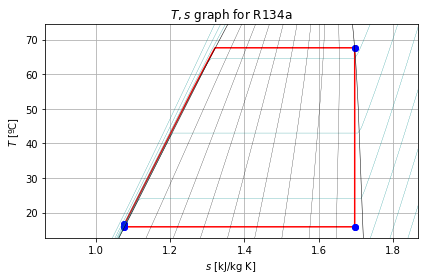

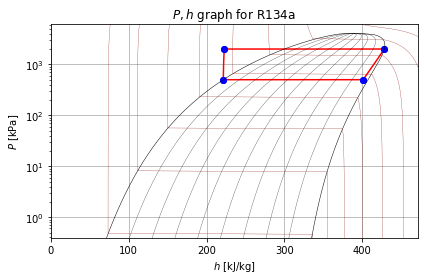

In [ ]:
rk = get_rankine(solution.x)
rk.printTable()
rk.plotGraphs()

In [ ]:
dh_co2 = rk.heat_in/rk.mass_flow
st_co2_in = State('CO2', T=T_co2_inlet_C + 273, P=P_co2_inlet_MPa*1e6)
st_co2_out = State('CO2', h = st_co2_in.h - dh_co2 , P=P_co2_inlet_MPa*1e6)
st_co2_injection = State('CO2', T = T_co2_injection_C + 273, P=P_co2_injection_MPa*1e6)

print('T CO2 H.E in:', round(st_co2_in.T-273,2), 'ºC')
print('T CO2 H.E out:', round(st_co2_out.T-273,2), 'ºC')
print('Cp average', round(st_co2_out.c/1000,2), 'kJ/kg')

T CO2 H.E in: 89.0 ºC
T CO2 H.E out: -21.52 ºC
Cp average 1.8 kJ/kg


In [ ]:
rk.getDf().to_csv('rankine_results.csv',index=False)
df_inputs.to_csv('rankine_inputs.csv',index=False)

rk.getDf()

,0,1,2
0,Fluid:,R134a,-
0,Mass flow,17.27,(kg/s)
0,Heat in,3549.5,(kW)
0,Heat out,3100.79,(kW)
0,Work turbine,469.55,(kW)
0,Work pump,20.83,(kW)
0,Work net,448.71,(kW)
0,Efficiency,12.64,(%)
0,P high,2,MPa
0,P low,0.5,MPa


In [ ]:
st1 = State('CO2', T=23+273, P=23.35e6)
st2 = State('CO2', s = st1.s, P=25.0e6)

((10*((st2.h-st1.h)/0.75))/(rk.work_net*0.75*0.8))*100


8.645352828171218

In [ ]:
P_high  = solution.x[0]
P_low   = solution.x[1]
m_cycle = solution.x[2]

m_geo = m_co2  #kg/s
#boiler_efficiency = 0.9
P_co2 = P_co2_inlet_MPa * 1e6
T_hot_geo = T_co2_inlet_C + 273

st_cond = State(fluid, x=0, P=P_low)
T_condenser = st_cond.T

st_boil_in = State(fluid,s= st_cond.s,P=P_high)
T_boil_in = st_boil_in.T

co2_in = State('CO2', P = P_co2, T=T_hot_geo)

C_co2, C_fluid = co2_in.c * m_geo , State(fluid, P = P_high, T=T_boil_in).c * m_cycle
C_min = min(C_co2, C_fluid)

Q_max = C_min*(T_hot_geo-T_boil_in)
print('C_co2:', C_co2)
print('C_fluid:', C_fluid)
print('C_min:', C_min)
print('Q_max:', Q_max/1000, 'kW')


co2_out = State('CO2', P = P_co2, T=co2_in.T - (Q_max/C_co2))

st1 = st_cond
st2 = st_boil_in
st3 = State(fluid, P=P_high, h = st2.h + (Q_max/m_cycle))
#st3 = State(fluid, P=P_high, T = st2.T + (Q_max/C_fluid))
st4 = State(fluid, P=P_low, s=st3.s)

rankine = SimpleRankine(m_cycle,fluid,st3,st4,st1,st2)

print(rankine.mass_flow * (st3.h - st2.h))

print()

print('T_co2_in:', co2_in.T)
print('T_co2_out:', co2_out.T)
print('T_R134a_in:', st_boil_in.T)
print('T_R134a_out:', st3.T)

rankine.work_net/1000

C_co2: 16787.394233342628
C_fluid: 23818.954761154648
C_min: 16787.394233342628
Q_max: 1215.1696443981548 kW
1215169.6443981552

T_co2_in: 362.0
T_co2_out: 289.6141593205323
T_R134a_in: 289.6141593205323
T_R134a_out: 336.6476737902722


94.6868184736876

In [ ]:
print('T CO2 H.E in:',round(co2_in.T - 273,2))
print('T CO2 H.E out:',round(co2_out.T - 273,2))
print('P CO2 H.E out:', eng(co2_out.P,'Pa'))
print('Cp CO2 H.E out:', eng(co2_out.c,'J/kg'))
print('rho CO2 H.E out:', round(co2_out.d,3),'kg/m3')


((co2_in.h - co2_out.h)*m_co2)/1000

T CO2 H.E in: 89.0
T CO2 H.E out: 16.61
P CO2 H.E out: 36.066 MPa
Cp CO2 H.E out: 1.836 kJ/kg
rho CO2 H.E out: 1018.72 kg/m3


1193.9638236851993